Before we get too far, lets import some packages we will need so we don't have to worry about them later...

In [415]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import scipy as sp

import matplotlib.pyplot as plt
# It would be great to use notebook here, but thats not supported???
%matplotlib inline


Examples should be from one freq for the beginning. 

Splitting data can just bring in a second one.

Why is xvalidation different from a residual computation-->address explicitly.

1st half vs second half vs random trials--> can we find a nice non-stationary cell??

We can swap in another session that has a nicer "running" session. This will (maybe) be a better thing for the splitting example.

Reference the data book- saskia will help

Add in a selectivity metric?? May not tie nicely to second half? Orientation selectivity.

check that the score function does what we think it does...
    score

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>0 Today</h2>

<p>Hubel and Wiesel found orientation and direction selective cells using single wire recordings in the cat primary visual cortex.

To do this, they used a "bespoke" technique - honing in on an individual cell with a high impedence electrode, then manually determining their "best" stimulus to drive that cells behavior. 

In our phasing, we will say that Hubel and Wiesel showed that their exist neurons in V1 that "encode" direction selective information. This was (and still is!) exciting - but it also raises more questions.

Using this idea as a starting place, this Workshop will show how to scale this kind of analysis to survey a population of neurons, and highlight some of the challenges that go with this.

</div>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2>0.1 Our Questions here </h2>

(1) Do mice have direction selective visual responses?

(2) How reliable are these responses?

(3) What do these responses look like in the neural population? Are is this a common phenomena? Is it consistant accross cells?

(4) How can we mathematically formalize this analysis?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>All of out examples today will use the Allen Brain Observatiory 2-photon dataset. Before we get started, lets find the dataset and ensure we can access it:
    
<p>The main entry point is the `BrainObservatoryCache` class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded into data assetts on codeocean - These data are big, and this will save us a lot of bandwidth and time.

    
<p> We begin by importing the `BrainObservatoryCache` class and instantiating it. Here, `manifest_path` is a path to the manifest file. 
</div>

In [411]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

#drive_path = '/data/allen-brain-observatory/visual-coding-2p'
drive_path = r'D:/VisualCoding2p'

manifest_file = os.path.join(drive_path,'manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

Not putting something after a item at the end of a notebook cell will cause it to exicute that items print function. For objects that don't have a print function, it will just print the object type. This can be handy during data exporation.

In [412]:
boc

In [413]:
# Other ways to do this
print(boc)
print(type(boc))

<class 'allensdk.core.brain_observatory_cache.BrainObservatoryCache'>


Jupyter and VS code will also help you out by giving you a menu of fuctions you can call on an object. This is a handy trick when learning a new library.

In [414]:
# Jupyter and VS code will also help you out by giving you a menu of fuctions
# you can call on an object. This is a handy trick when learning a new library.
boc.

SyntaxError: invalid syntax (2964336537.py, line 3)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1 Do Mice Have Direction Selective Neurons?

## 1.0 Why bother with mice when we got here using with cats?
Simply put, there are better tools availible for recording and manipulating neural circuits in mice. Because mice have a short generation time, their exist a plethera of genetic tools that exist in mice and not yet in other mammels. The most relevent of these - Ca2+ imaging - makes possible to repeatdily record from a realativly large population of neurons, and therefore make mice the ideal animal for this kind of experiment.

That said, mice are not cats and have very different visual systems. A necessary prerequisite to any sort of survey work will be to demonstrate that mice have similar responses to those seen in other mammels!
    
    
## 1.1 Visual stimulus
 
    
## 1.1.0 Head Fixation
Neurons in the visual system often have spacially selective receptive fields, that is, they tend to repsond to stimuli shown in a particular part of visual space. In order to repeatably show stimuli to a mouse, the mice need to be head-fixed. For all the datasets you will work with here, this means that mice have had a head-bar surgically implanted prior to the experiment (Groblewski et al 2022). 

![Headframe](../resources/Groblewski_head_fixed_mouse.jpg)

This headbar can be repetably clamped into a recording setup. The clamp used in these experiments does so with < 10um precision. 

![Headframe positioning](../resources/Groblewski_head_bar_lock_in.jpg)

Head fixation allows two things. 

First, this relability allows the mouse to be repoducibly positioned on a rig. For the datasets you will work with in the next couple of weeks, this typically means that the mosue is situatied on a running wheel. A set of cameras monitor the mouse's face, eye position, and pupil size (Cite whitepaper here).

![Mouse On Rig](../resources/MouseOnRig.jpg)

A screen holds positioned in front of the mice can then present stimuli at specific locations in the mouse's field of view. Here, all stimuli were presented to the right side of the mouse.

![Screen On Rig](../resources/ScreenOnRig.jpg)

The second benifit of head fixation is that it holds the mouses head place to facilitate neural recordings. We will return to this in the next session.

## 1.1.1 Visual Stimulation

Now that the mouse is in a repeatable position, it can be shown stimuli. The t Allen Brain Observatory dataset used a battery of stimuli. These includestatic gratings, drifiting gratings, locally sparse noise, natural scenes, and some natural movies. The data also includes periods of no stimulus, which allow for "spontainous" (or at least unstimuluated) neural activity. 

![Visual Stimuli](../resources/VisualStimuli.jpg)



We can use the BrainObservatoryCache to see all the stimuli used:


In [416]:
boc.get_all_stimuli()

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']

For today's workshop, though, our question is focused on direction selectivity. This means that it makes the most sense to use drifting gratings. Here, gratings are shown accross the whole screen, but moved accross it in specific directions at specific temporal frequencies. The BrainObservatoryCache can rapidly give us an idea about how much data we might have to answer this quesiton. Hint: its a lot.

In [264]:
sessions_with_drifting_gratings = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
len(sessions_with_drifting_gratings)

456

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.3 Record Neurons 

## 1.3.0 Every recording is baised; its important to know how.

Our goal here is to look at the activity of individual neurons. In this course, you will see data from two primary ways of doing this; in vivo electophysiology (e.g NeuroPixels data) and 2-photon calcium imaging data. 

This is no one right way to record neural activity- each method has its pluses and minuses. Many of you may have in depth understandings of one or both of these methods, but lets think for a moment about how you might select a recording technique to tackle a particual scientific question.

## 1.3.0.1 In Vivo Electrophysiology 
In vivo electrophysiology is where you park an electrode next to a cell and record extracellular ion flow from each action potential. 

![neuropixels cartoon](../resources/Model_of_mouse_v1_Barry_Isralewitz_braincontest2021.jpg)

Advantages: 
- Extreamly high time resolution (as fast as you care to sample it). 
- Record from deep structures using longer probes.
- Laminar and structural information
- Record from many structures simultaniously


Disadvantages: 
- You don't know a lot of information about the cells you are recording from.
- Spike sorting - the art of isolating neurons - is an unsolved problem.
- May be baised towards certain kinds of cells (big and/or high firing rate).
- Historically low cell yields per experiment.
- Cannot return to a cell accross sessions or experiments.


## 1.3.0.1 2-Photon Calcium imaging
Calcium imaging is an optical technique. Neurons are geneticially modified to express a GCaMP, a genetically encoded calium indictor that attaches Green Fluorecent Protien (GFP) to calmodulin, a calcium binding protine. As a result, cells will fluoress in a  green wavelenth when these is a calcium influx into the cell. Since calcium concentration spikes during action potentials, this allows for optical imaging of a given cells activity. 

Here is what this looks like when you stimulate a neuron and simultaniously record its electrophysiological (in this case, via patch clamp) and Ca2+ response (Stosiek et al. 2003, PNAS). Notice that there is a single, slow calcium transient for a much faster burst of spikes.

![https://www.pnas.org/doi/10.1073/pnas.1232232100 Stosiek et al 2003](../resources/EphysAndCa2.jpg)


As an historical aside, GFP was discovered here, at Friday Harbor, from the fluoressent jelly fish Aequorea victoria. 

![https://www.thoughtco.com/green-fluorescent-protein-facts-4153062](../resources/AequoreaVictoria.jpg)


Advantages:
- Cell type information by only expressing Ca2+ indicators in certain cell types.
- Return to specific identified cells accross sessions.

Disadvantages
- Activity is recorded indirectly using Ca2+ signal.
- Relativly poor time resolution.
- Limited to one or a few specific fields of view. In these data, that means a specific depth plane, though state-of-the-art techniques can now scan 3d volumes.
- Limated depth without implanting fancy (and distructive) lenses.

## 1.3.0.3 These pro-con lists are subject to change!
We would be remiss if we didn't point out that the these advantages and dissadvantages are rappidly changing, so fucture experiments might choose different methods for different reasons. 
- Ca2+ indicators are getting faster.
- Multi-photon methods are extending the depth-of-field for Ca2+ techniques.
- Better optics are allowing for imaging in deep structures and 3D fields of view.
- Optotagging allows for cell type identification in ephys.
- High density probes inprove cell yeilds in ephys.



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


## 1.3.1 Looking at Ca2+ data
For today's question, we want to charecterize a population of neurons in visual cortex. This means Ca2+ data makes sense to answer our questions, and we are going to dive deaper into data from the Allen Brain Observatory optical dataset. you will learn more about an analgous ephys dataset tomorrow!

### 1.3.1.1 Intrensic signal imaging to identify brain areas
Intrensic signal imaging is a technique that optically measures hemodyanmic - effectivly changes in blood oxygenation. While it has poor resolution in space and time, it has the distinct advantange of not requiring any fancy dyes or transgenic lines. Because each visual area has a distinct hemodyanimic response to visual stimulation, ISI allows for mapping and localication of specific brain regions. For all the mice in the Brain Observatory, ISI was performed to identify specific visual cortical areas.

![ISI](../resources/ISI.jpg)



Recordings are targeted to particular visual areas and depths. We can see which ones using the BrainObservatoryCache.

In [418]:
targeted_structures = boc.get_all_targeted_structures()
print('all targeted structures: ' + str(targeted_structures))

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


In [419]:
depths = boc.get_all_imaging_depths()
print('all imaging depths: ' + str(depths))

all imaging depths: [175, 185, 195, 200, 205, 225, 250, 265, 275, 276, 285, 300, 320, 325, 335, 350, 365, 375, 390, 400, 550, 570, 625]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.3.1.2 Cre Lines and Cortical layers
Calcium imaging only works if a calcium indicatior (here GCaMP) is expressed in cells. Mice are bred express these indicators in particular cell types using the genetic toolkit based around a Cre-Lox system. A genetic line of mice is called a "cre line," with each cre line expressing the GCaMP only in a certain set of genetically targeted cells. Ideally, a cre-line will target a particular cell type (though not all are perfect).
    
(probably cut this, link to 'book' instead).

https://help.brain-map.org/display/observatory/Allen+Brain+Observatory+-+Overview#:~:text=Intrinsic%20signal%20imaging%20%28ISI%29%20measures%20hemodynamic%20response%20to,field%20to%20corresponding%20locations%20within%20responsive%20cortical%20areas.

In [267]:
# Download a list of all imaging depths
cre_lines = boc.get_all_cre_lines()
print('all cre lines: ' + str(cre_lines))

all cre lines: ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Fezf2-CreER', 'Nr5a1-Cre', 'Ntsr1-Cre_GN220', 'Pvalb-IRES-Cre', 'Rbp4-Cre_KL100', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre', 'Slc17a7-IRES2-Cre', 'Sst-IRES-Cre', 'Tlx3-Cre_PL56', 'Vip-IRES-Cre']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Experiment containers</h2>
 
<p> Now we are ready to access some data!
    
<p>An experiment container describes a set of 3 experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. Note that this targeting is not perfect- many cells will overlap between sessions, but not all. 

Each experiment container has a unique ID number. 
</div>

For the sake of this workshop, lets all grab the same experiment container and loop at some of the info about it. 

In [421]:
expt_container_id = 511507650#536323956

In [422]:
expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id])
expt_session_info_df = pd.DataFrame(expt_session_info)
expt_session_info_df

,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,501794235,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),107,511507650,three_session_B,222424,Cux2-CreERT2;Camk2a-tTA;Ai93-222424,True
1,500855614,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),94,511507650,three_session_C,222424,Cux2-CreERT2;Camk2a-tTA;Ai93-222424,True
2,502115959,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),111,511507650,three_session_A,222424,Cux2-CreERT2;Camk2a-tTA;Ai93-222424,True


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Dataset Object</h2>
<p>Each session has a unique `session_id.' These can be used to query a data_set object, wich contains information specific to that session.

</div>

We know that session type "three_session_A" included drifting grating stimuli, so we can specificly query the experiment session info dataframe that we just made and use this info to get the relevent dataset object.

In [270]:
session_id= expt_session_info_df[expt_session_info_df.session_type=='three_session_A'].id.iloc[0]
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

The dataset object contains all of the relevent metadata, which we might want to use to query similar sessions.

In [423]:
data_set.get_metadata()

{'sex': 'male',
 'targeted_structure': 'VISp',
 'ophys_experiment_id': 502115959,
 'experiment_container_id': 511507650,
 'excitation_lambda': '910 nanometers',
 'indicator': 'GCaMP6f',
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'session_start_time': datetime.datetime(2016, 2, 12, 12, 46, 45),
 'session_type': 'three_session_A',
 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222424',
 'cre_line': 'Cux2-CreERT2/wt',
 'imaging_depth_um': 175,
 'age_days': 112,
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'pipeline_version': '3.0'}

It also contains df/f traces for all of the identified cells.

In [424]:
data_set.get_dff_traces()

(array([   9.56432,    9.59757,    9.63082, ..., 3849.24145, 3849.27471,
        3849.30796]),
 array([[0.15853682, 0.13146706, 0.11839136, ..., 0.114178  , 0.16732922,
         0.18347007],
        [0.2540163 , 0.2083273 , 0.15291882, ..., 0.05636624, 0.1076358 ,
         0.08158059],
        [0.07768381, 0.04211425, 0.0199153 , ..., 0.05188671, 0.0825967 ,
         0.18528701],
        ...,
        [0.19356981, 0.04253679, 0.14183588, ..., 0.1623657 , 0.1823231 ,
         0.1996536 ],
        [0.23961927, 0.20226482, 0.13222878, ..., 0.04495161, 0.01830056,
         0.15311603],
        [0.3486403 , 0.27084935, 0.24234743, ..., 0.05000732, 0.02596113,
         0.10972904]], dtype=float32))

Because we are working with imaging data, it can sometimes be helpfult to look at the origional data. The dataset object does not include the origional videos, but it does include a max projection image and the cell segmentation used to isolate the df/f traces we will be analysing.

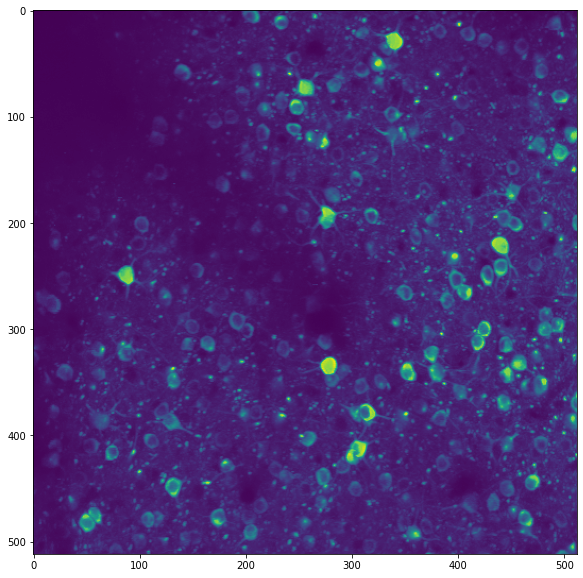

In [433]:
mxproj = data_set.get_max_projection()
fig,ax  = plt.subplots(figsize = (10,10))
ax.imshow(mxproj)

Number of labels: 206


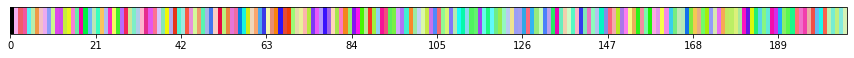

In [434]:
# This is just fancy code to give each cell a random, unique color - don't worry
# about it. If you really want to see whats happening, you can look at the code
# in 'helperfunctions.py'
from helperfunctions import rand_cmap
cm = rand_cmap(len(msks)+1)

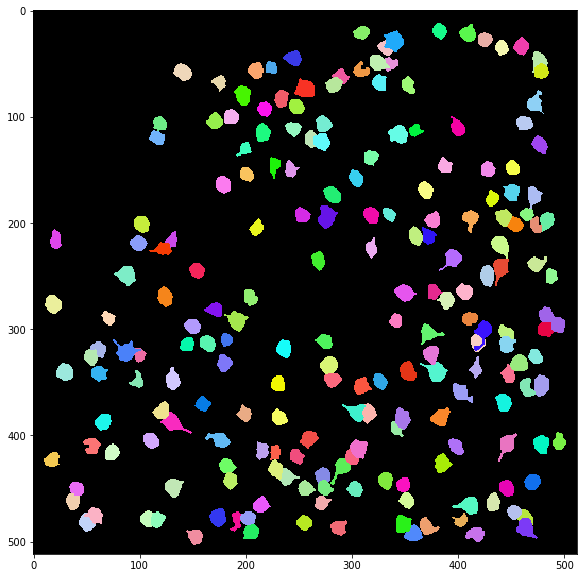

In [435]:
msks = data_set.get_roi_mask_array()

roi_id = np.zeros(msks[0].shape)
for ii, msk in enumerate(msks):
    roi_id[msk==1] = ii
fig,ax  = plt.subplots(figsize = (10,10))
ax.imshow(roi_id,cmap =cm,interpolation = 'none')


In [436]:
gratings = boc.get_ophys_experiment_analysis(ophys_experiment_id=session_id, stimulus_type='drifting_gratings')
gratings.dfftraces.shape

(205, 115470)

Finally, we can plot the df/f trace for an individual roi (cell).

In [438]:
#cell_id = 541513979
#cell_idx = np.where(cell_id==gratings.cell_id)[0][0]
cell_idx = 7

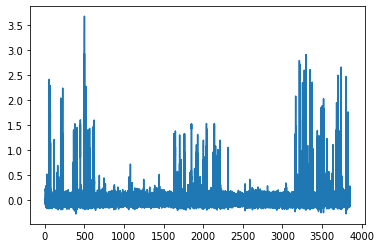

In [439]:
this_dff = gratings.dfftraces[cell_idx]
plt.plot(gratings.timestamps,this_dff)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Analysis Object</h2>


<p>The analysis objects summarize the trial data for a stimulus type and provide convenient DataFrame objects.  
</div>

In [440]:
gratings = boc.get_ophys_experiment_analysis(ophys_experiment_id=session_id, stimulus_type='drifting_gratings')
gratings.dfftraces.shape

(205, 115470)

This object includes useful things, like a table of all the drifting grating stimuli shown.

In [442]:
stim_table = gratings.stim_table
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,2.0,45.0,0.0,746,806
1,15.0,90.0,0.0,837,896
2,4.0,90.0,0.0,927,987
3,2.0,45.0,0.0,1017,1077
4,4.0,90.0,0.0,1108,1167


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Now we have data to work with!
    
This means we can start actually plotting some of stimulus responses for specific stimuli.

Here, we know the frame rate for our data is about 30 Hz, and we know that stimuli were show for 2 seconds. We can use this information to plot data centered around the trial start, with a buffer on each side.

A quick note- here, we are approximating time by assuming a 30 Hz sampling rate. This isn't stricktly true; if you look at the timestamps for a session, they do not always have consistant interfvals. What is more, if we round stimulus presentation to the nearest timestamp we do not always get exactly the same trial length (some are 60 frames, some are 59). So, while this approximation is fine for what we are doing here, it might not always be a safe thing to do!

Text(0.5, 0, 'Frames')

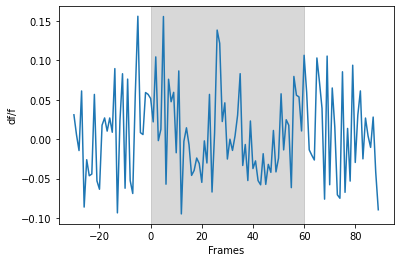

In [471]:
tme = np.arange(int(stim_table.start[0])-30,int(stim_table.end[0])+30,1)-int(stim_table.start[0])

plt.plot(tme,this_dff[int(stim_table.start[0])-30:int(stim_table.end[0])+30])
plt.axvspan(0,60, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("df/f")
plt.xlabel("Frames")


Now lets grab a (more interesting) trial.

Text(0.5, 0, 'Frames')

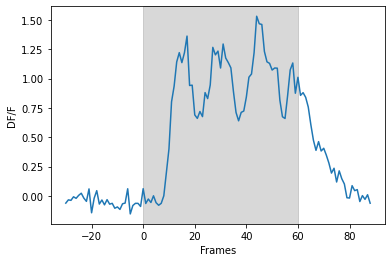

In [474]:
tme = np.arange(int(row.start)-30,int(row.end)+30,1)-int(row.start)
plt.plot(tme,this_dff[stim_table.start[115]-30:stim_table.end[115]+30])
plt.axvspan(0,60, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")


We can filter the stim table to look for all the trails of this type

In [480]:
stim_table.iloc[115]

temporal_frequency        2.0
orientation             315.0
blank_sweep               0.0
start                 11132.0
end                   11191.0
Name: 115, dtype: float64

In [481]:
this_stim_table = gratings.stim_table[(gratings.stim_table.temporal_frequency==2) & (gratings.stim_table.orientation==315)]
this_stim_table

,temporal_frequency,orientation,blank_sweep,start,end
115,2.0,315.0,0.0,11132,11191
162,2.0,315.0,0.0,15375,15435
170,2.0,315.0,0.0,16098,16157
196,2.0,315.0,0.0,18445,18505
201,2.0,315.0,0.0,48696,48756
246,2.0,315.0,0.0,52759,52819
340,2.0,315.0,0.0,61248,61307
371,2.0,315.0,0.0,64047,64106
376,2.0,315.0,0.0,64498,64558
418,2.0,315.0,0.0,96283,96342


In [482]:
len(this_stim_table)

15

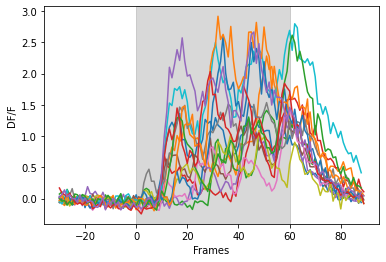

In [483]:
plt.axvspan(0,60, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented

# THIS IS A SUPER HANDY WAY TO INTERATE THROUGH A TABLE!!!
for ii,row in this_stim_table.iterrows():
    tme = np.arange(int(row.start)-30,int(row.end)+30,1)-int(row.start)
    plt.plot(tme,this_dff[int(row.start)-30:int(row.end)+30])
    plt.ylabel("DF/F")
    plt.xlabel("Frames")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## 1.3 Are there direction selective cell in mouse primary visual cortex?


For each trial, lets get the orientation, temporal frequency, and response for this cell.

In [485]:
orientation = np.zeros((len(stim_table)))
temp_freq = np.zeros((len(stim_table)))
response = np.zeros((len(stim_table),60))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    response[ii,:] = this_dff[stim_table.start[ii]:stim_table.start[ii]+60]

In [486]:
response.shape

(628, 60)

For now, we can subsample only to the temporal frequency we were looking at before.

In [487]:
orientation = orientation[temp_freq==2]
response = response[temp_freq==2,:]

In [488]:
orientations,ix = np.unique(orientation,return_inverse=True)
print(orientations)


[  0.  45.  90. 135. 180. 225. 270. 315.]


In [489]:
# The variable 'ix' maps the values in 'orientation' to the values in
# 'orientations'
print(ix[1:10])
print(orientation[1:10])
print(orientations[ix[1:10]])

[1 5 6 2 4 6 6 0 0]
[ 45. 225. 270.  90. 180. 270. 270.   0.   0.]
[ 45. 225. 270.  90. 180. 270. 270.   0.   0.]


Before we get too far, we are going to divide the data in half. Don't worry too much about this right now - eventually it will allow us to quantify some of the variability in our data, but we will talk about this at lenght later.

In [490]:

divider = len(orientation)//2

orientation_a = orientation[:divider]
orientation_b = orientation[divider:]
temp_freq_a = temp_freq[:divider]
temp_freq_b = temp_freq[divider:]
response_a = response[:divider,:]
response_b = response[divider:,:]
ix_a = ix[:divider]
ix_b = ix[divider:]


Text(0.5, 0, 'time (frames from stim onset)')

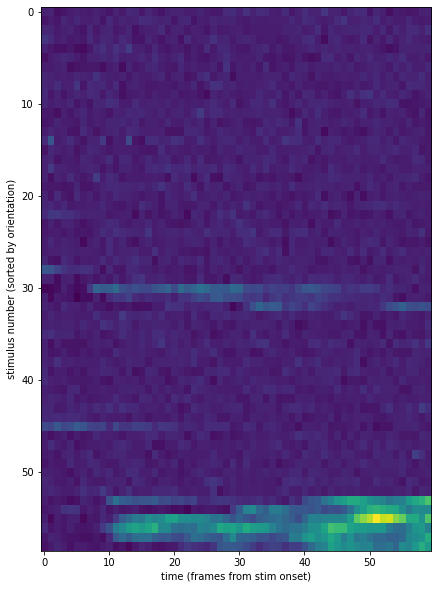

In [491]:
sort_order = np.argsort(ix_a)
fig,ax = plt.subplots(figsize=(7,10))
ax.imshow(response_a[sort_order,:],aspect='auto')
ax.set_ylabel('stimulus number (sorted by orientation)')
ax.set_xlabel('time (frames from stim onset)')


It is going to be easier to look at each response as a single number, rather than a 2-second timeseries. For this, we can simply use the average df/f response observed during each trial. Because all our time windows here are the same length, this will be proportional to the area under each reponse curve.

In [495]:
mean_response_a = response_a.mean(axis =1)
mean_response_b = response_b.mean(axis =1)

In [496]:
mean_response_b.shape

(60,)

Text(0, 0.5, 'Trial Mean DF/F')

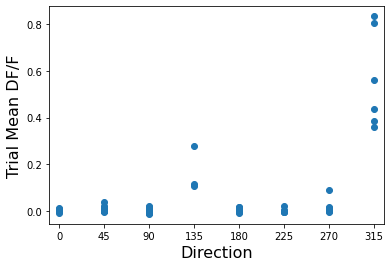

In [497]:
plt.plot(orientation_a, mean_response_a, 'o')
plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Trial Mean DF/F", fontsize=16)

Text(0, 0.5, 'Mean DF/F')

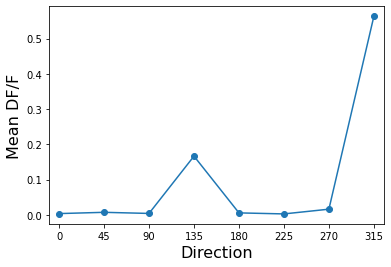

In [498]:
tuning_a = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    tuning_a[ii] = mean_response_a[ix_a==ii].mean()
plt.plot(orientations,tuning_a, 'o-')
plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Should code about descriptive stats go here?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

# 2 How reliable are these responses?


We can use our tuning curve as a simple model of the receptive field if we use it like a look up table: for each stimulus direction, we know what the mean reponse of the cell will be. Using the index established above, we can query the tuning curve for the expected response amplitude of the cell.

In [522]:
prediction_aa = tuning_a[ix_a]

Text(0, 0.5, 'Predicted DF/F')

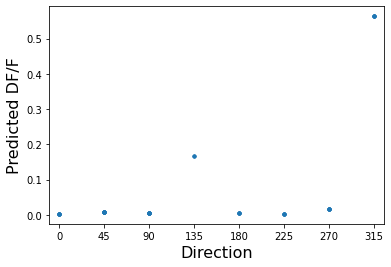

In [523]:
plt.plot(orientation_a,prediction_aa, '.')
plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Predicted DF/F", fontsize=16)
# Notice that even though there are multiple trials at each direction, 
# they all get the same prediction.

One method for quantifying how well a prediction does is to simply compute the prediction error, that is, how far off the prediction was from the observed value. These are also called the model residuals.

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  7., 38.,  5.,
         1.,  1.,  0.,  1.,  0.,  0.,  2.]),
 array([-0.27006014, -0.2464426 , -0.22282505, -0.19920751, -0.17558997,
        -0.15197242, -0.12835488, -0.10473733, -0.08111979, -0.05750224,
        -0.0338847 , -0.01026716,  0.01335039,  0.03696793,  0.06058548,
         0.08420302,  0.10782056,  0.13143811,  0.15505565,  0.1786732 ,
         0.20229074]),
 <BarContainer object of 20 artists>)

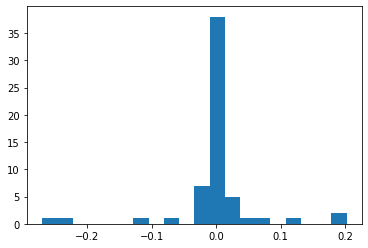

In [524]:
error = prediction_aa- mean_response_a
fig,ax = plt.subplots()
ax.hist(error,bins=20)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
By itself, though, error can be difficult to interpret.
    
One popular metric for assessing this kind of mode is the "coefficient of determination," or $R^2$. $R^2$ asks compares the variance in the model residuals, $V_{residuals}$, to the varaince in the data overall $V_{total}$, effectivtly asking "How much of the variance in our data is explained by our model?"
    
 $$R^2 = 1-\frac{V_{residuals}}{V_{total}}$$

Because a perfect model will have zero residuals and worthless model will explain no variance, subtracting this ratio from 1 lends interpretability. A perfect model will have zero residuals, and therefore $R^2=1$. If no variance is explained $R^2$ will equal 0. If a model introduces unexplained variance, $R^2$ can even be less than 1.

Time to try it!

In [525]:
residuals_aa  =  np.mean((error)**2)
residuals_aa

0.00423454895917721

In [526]:
total_variance_aa = np.mean((mean_response_a-np.mean(mean_response_a))**2)
total_variance_aa

0.03288210701856388

In [527]:
r2_aa = 1-residuals_aa/total_variance_aa
r2_aa

0.8712202670958233

Text(0, 0.5, 'Mean DF/F')

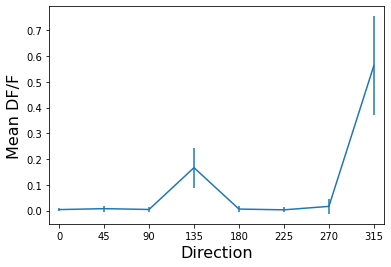

In [528]:
stdev_a = np.zeros(orientations.shape)
for ii in range(orientations.shape[0]):
    stdev_a[ii] = mean_response_a[ix_a==ii].std()

plt.errorbar(orientations,tuning_a,stdev_a)
plt.xticks(orientations)
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
You will probably have noticed that we split our data in half before we fit our initial model.
    
This is because, up to this point, we have been building our model on the same data we are using to quantify its predictive power. What we really want to know, though, is how well this model can predict data that it has never seen before. Splitting the data early on gives us an additional set of trials with which to test these model predictions.
    

Look at the data from both parts of the split.

Text(0, 0.5, 'Mean DF/F')

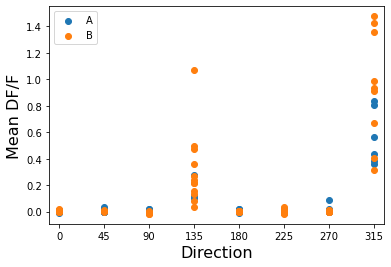

In [530]:
plt.scatter(orientation_a, mean_response_a,label = 'A')
plt.scatter(orientation_b, mean_response_b,label = 'B')

plt.xticks(orientations)
plt.legend()
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

We can make predictions about out 'testing' data using the same indexing technique.

In [535]:
prediction_ab = tuning_a[ix_b]

Computing $R^2$ is something that we are likely going to want to do many times. It is therefore helpful to write a function that tackles what we did earier,

In [536]:
def compute_coefficient_of_determination(mean_response,prediction):
    """
    Compute the coefficient of determination (R^2) for a set of data
    Parameters
    ----------
    mean_response : np.array
        The mean response for each stimulus
    prediction : np.array
        The predicted response for each stimulus
    
    Returns
    -------
    r2 : float
        The coefficient of determination
    """

    residual = mean_response-prediction
    sum_of_squared_residual  =  np.mean((residual)**2)
    total = np.mean(mean_response)-mean_response
    sum_of_squared_total  =  np.mean((total)**2)
    r2 = 1-sum_of_squared_residual/sum_of_squared_total
    return r2

In [537]:
r2_ab = compute_coefficient_of_determination(mean_response_b,prediction_ab)
r2_ab

0.5684349988106826

Now that we have fit a model to one cell, lets try some others. 

Here, we repeat what we did above, but this time use an additional for-loop to compute the response for every cell on every trial. 

In [538]:
orientation = np.zeros((len(stim_table)))
temp_freq = np.zeros((len(stim_table)))
response = np.zeros((len(stim_table),60))
mean_response_all = np.zeros((len(stim_table),len(gratings.cell_id)))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    for cc in range(len(gratings.cell_id)):
        this_response =  gratings.dfftraces[cc][stim_table.start[ii]:stim_table.start[ii]+60]
        mean_response_all[ii,cc] = this_response.mean()

mean_response_all = mean_response_all[temp_freq==2,:]
        
        
mean_response_all_a = mean_response_all[:divider,:]
mean_response_all_b = mean_response_all[divider:,:]



In [403]:
#new_cell_id = 541512233
#this_index = np.where(gratings.cell_id==new_cell_id)[0][0]



In [404]:
def compute_tuning_curve(mean_response,orientation,orientations):
    """
    Compute the tuning curve for a set of data
    """
    tuning = np.zeros(orientations.shape)
    stdev = np.zeros(orientations.shape)
    for ii,ori in enumerate(orientations):
        tuning[ii] = mean_response[orientation==ori].mean()
        stdev[ii] = mean_response[orientation==ori].std()
    return tuning,stdev
    

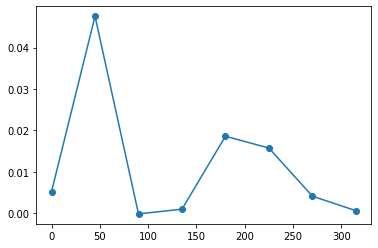

In [539]:
this_index =5

this_tuning_a,this_stdev_a = compute_tuning_curve(mean_response_all_a[:,this_index],orientation_a,orientations) 

plt.plot(orientations,this_tuning_a, 'o-')



In [540]:
print(compute_coefficient_of_determination(mean_response_all_a[:,this_index],this_tuning_a[ix_a]))
# Thought experiment: What to negative numbers mean here?


0.0963007073374823


Text(0, 0.5, 'Mean DF/F')

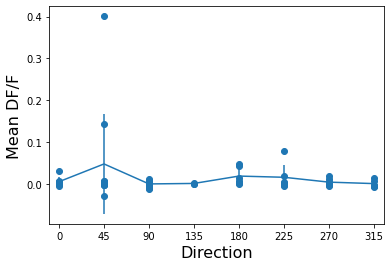

In [541]:
fig,ax = plt.subplots()

ax.errorbar(orientations,this_tuning_a,this_stdev_a,)
ax.scatter(orientation_a,mean_response_all_a[:,this_index])

ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Mean DF/F", fontsize=16)

In [542]:
mean_response_all_b[:,this_index].shape
#orientation_a.shape

(60,)

In [543]:
fig,ax = plt.subplots()
ax.plot(orientations,this_tuning_a, '-',label = '1st half')
ax.scatter(orientation_a,mean_response_all_a[:,this_index])
this_tuning_b,this_stdev_b = compute_tuning_curve(this_tuning_b,this_stdev_b = compute_tuning_curve(mean_response_all_b[:,this_index],orientation_b,orientations)
[:,this_index],orientation_b,orientations)
ax.plot(orientations,this_tuning_b, '-',label = '2nd half')
ax.scatter(orientation_b,mean_response_all_b[:,this_index])
print(compute_coefficient_of_determination(mean_response_all_b[:,this_index],this_tuning_a[ix_b]))
ax.set_xticks(orientations)
ax.set_xlim(-10,325)
ax.set_xlabel("Direction", fontsize=16)
ax.set_ylabel("Mean DF/F", fontsize=16)
ax.legend()


SyntaxError: positional argument follows keyword argument (32368911.py, line 5)

So... a 'peak' in a tuning curve DOES NOT necessarily mean the cell is reliably tuned!

# 3 What do responses look like an a neural population?

In [521]:

many_r2_aa = np.zeros(len(gratings.cell_id))
many_r2_ab = np.zeros(len(gratings.cell_id))
another_tuning_a = np.zeros((len(gratings.cell_id),orientations.shape[0]))
another_stdev_a = np.zeros((len(gratings.cell_id),orientations.shape[0]))

another_tuning_b = np.zeros((len(gratings.cell_id),orientations.shape[0]))
another_stdev_b = np.zeros((len(gratings.cell_id),orientations.shape[0]))

for cc in range(len(gratings.dfftraces)):
    another_dff = gratings.dfftraces[cc]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        # Note that this is  the same session, so we can assume the same
        # stimulus order!
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]
    another_mean_response = another_response.mean(axis =1)

    another_mean_response_a = another_mean_response[:divider]
    another_mean_response_b = another_mean_response[divider:]

    another_tuning_a[cc,:],_ = compute_tuning_curve(another_mean_response_a,orientation_a,orientations)

    for ii in range(orientations.shape[0]):
        another_tuning_a[cc,ii] = another_mean_response_a[ix_a==ii].mean()
        another_stdev_a[cc,ii] = another_mean_response_a[ix_a==ii].std()
        another_tuning_b[cc,ii] = another_mean_response_b[ix_b==ii].mean()
        another_stdev_b[cc,ii] = another_mean_response_b[ix_b==ii].std()
    another_prediction_aa = another_tuning_a[cc,ix_a]
    another_prediction_ab = another_tuning_a[cc,ix_b]

    many_r2_aa[cc] = compute_coefficient_of_determination(another_mean_response_a,another_prediction_aa)
    many_r2_ab[cc] = compute_coefficient_of_determination(another_mean_response_b,another_prediction_ab)
    

IndexError: boolean index did not match indexed array along dimension 0; dimension is 569 but corresponding boolean dimension is 60

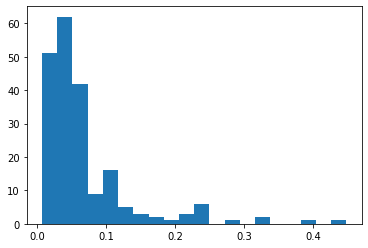

In [143]:
fig,ax = plt.subplots()
ax.hist(many_r2_aa,bins=20);


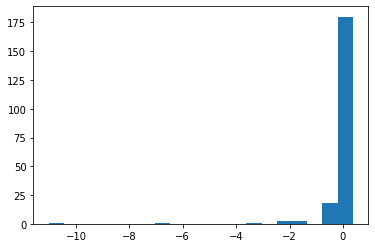

In [144]:
fig,ax = plt.subplots()
ax.hist(many_r2_ab,bins=20);
# Yikes!

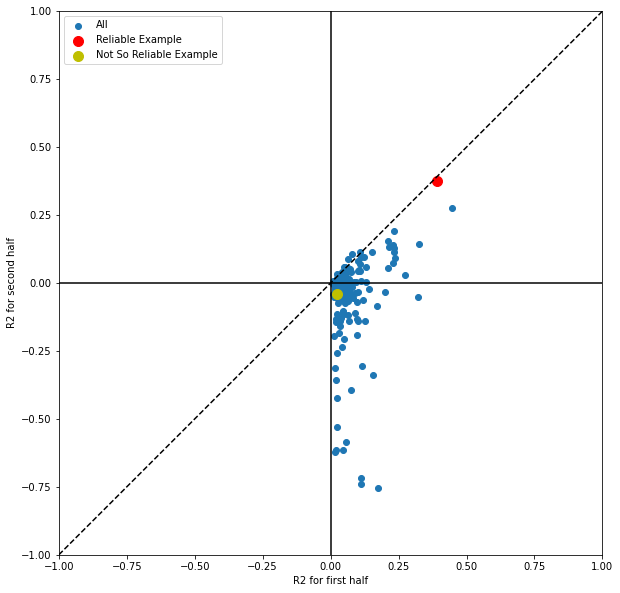

In [145]:
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(many_r2_aa,many_r2_ab,label = 'All')
ax.scatter(r2_aa,r2_ab,c='r',s=100,label = 'Reliable Example')
#this_index = np.where(gratings.cell_id==new_cell_id)[0][0]
ax.scatter(many_r2_aa[this_index],many_r2_ab[this_index],c='y',s=100,label = 'Not So Reliable Example')

ax.plot([-1,1],[-1,1],'k--')
ax.plot([-1,1],[0,0],'k')
ax.plot([0,0],[-1,1],'k')
ax.set_xlabel('R2 for first half')
ax.set_ylabel('R2 for second half')
ax.set_xlim(-1,1) # The lower bound here is arbitrarty...
ax.set_ylim(-1,1)
ax.set_aspect('equal')

ax.legend()

In [146]:
np.argmax(many_r2_ab)

7

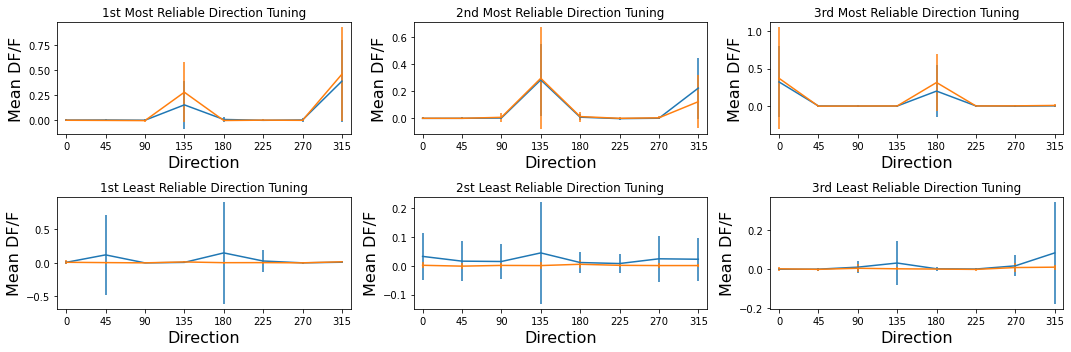

In [147]:
order = np.argsort(many_r2_ab)
fig,ax = plt.subplots(ncols=3,nrows=  2,figsize=(15,5))
ax[0,0].errorbar(orientations, another_tuning_a[order[-1]],another_stdev_a[order[-1]],)
ax[0,0].errorbar(orientations, another_tuning_b[order[-1]],another_stdev_b[order[-1]],)
ax[0,0].set_title('1st Most Reliable Direction Tuning')

ax[0,1].errorbar(orientations, another_tuning_a[order[-2]],another_stdev_a[order[-2]],)
ax[0,1].errorbar(orientations, another_tuning_b[order[-2]],another_stdev_b[order[-2]],)
ax[0,1].set_title('2nd Most Reliable Direction Tuning')

ax[0,2].errorbar(orientations, another_tuning_a[order[-3]],another_stdev_a[order[-3]],)
ax[0,2].errorbar(orientations, another_tuning_b[order[-3]],another_stdev_b[order[-3]],)
ax[0,2].set_title('3rd Most Reliable Direction Tuning')


ax[1,0].errorbar(orientations, another_tuning_a[order[0]],another_stdev_a[order[0]],)
ax[1,0].errorbar(orientations, another_tuning_b[order[0]],another_stdev_b[order[0]],)
ax[1,0].set_title('1st Least Reliable Direction Tuning')


ax[1,1].errorbar(orientations, another_tuning_a[order[1]],another_stdev_a[order[1]],)
ax[1,1].errorbar(orientations, another_tuning_b[order[1]],another_stdev_b[order[1]],)
ax[1,1].set_title('2st Least Reliable Direction Tuning')

ax[1,2].errorbar(orientations, another_tuning_a[order[2]],another_stdev_a[order[2]],)
ax[1,2].errorbar(orientations, another_tuning_b[order[2]],another_stdev_b[order[2]],)
ax[1,2].set_title('3rd Least Reliable Direction Tuning')

for ii,x in enumerate(ax.flatten()):
    x.set_xticks(orientations)
    x.set_xlim(-10,325)
    x.set_xlabel("Direction", fontsize=16)
    x.set_ylabel("Mean DF/F", fontsize=16)
    


fig.set_tight_layout(True)


## 3.1 There is more than one way to split your data.
Up till now, all our analysis has focus on data that were split into the first and second halves of the behavior session. 

How, exactly, you split your data can have a profound impact on the question you are asking. Here,this means that our question wasn't just about the consistancy of data- it was about stability of neural responses between the first and second half of the session. 

One valid alternative would have been to grab random halves. Another might have been to grab alternating trials under each experiment condition. All of these would have told us something about neural consistancy, but each would have asked subtily different questions about our data and each would have made subtily different assumtions going in.

### 3.1.1 You can use carful data splits to answer scientific questions.

So far, we have thought about variability as a problem. Now though, lets try a stratigic split accross experimental conditions to see if we can learn something.




In [255]:
fast_freqs = temp_freq>=2

slow_freqs = temp_freq<2


In [256]:
fast_freqs_1 = np.bitwise_and(fast_freqs,stim_table.index<divider)
fast_freqs_2 = np.bitwise_and(fast_freqs,stim_table.index>=divider)

In [257]:
new_cell_id = 541513083
this_index = np.where(gratings.cell_id==new_cell_id)[0][0]

this_tuning_fast_1,this_stdev_fast_1 = compute_tuning_curve(mean_response_all[fast_freqs_1,this_index],orientation[fast_freqs_1],orientations) 
this_tuning_fast_2,this_stdev_fast_2 = compute_tuning_curve(mean_response_all[fast_freqs_2,this_index],orientation[fast_freqs_2],orientations) 
this_tuning_slow,this_stdev_slow = compute_tuning_curve(mean_response_all[slow_freqs,this_index],orientation[slow_freqs],orientations) 

fig,ax = plt.subplots()
ax.errorbar(orientations,this_tuning_fast_1,this_stdev_fast_1)
ax.scatter(orientation[fast_freqs_1],mean_response_all[fast_freqs_1,this_index],label = 'Fast Freqs')

ax.errorbar(orientations,this_tuning_fast_2,this_stdev_fast_2)
ax.scatter(orientation[fast_freqs_2],mean_response_all[fast_freqs_2,this_index],label = 'Fast Freqs')

ax.errorbar(orientations,this_tuning_slow,this_stdev_slow)
ax.scatter(orientation[slow_freqs],mean_response_all[slow_freqs,this_index],label = 'Slow Freqs')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [1065]:
many_r2_ff= np.zeros(len(gratings.cell_id))

many_r2_fs = np.zeros(len(gratings.cell_id))
another_tuning_moving = np.zeros((len(gratings.cell_id),orientations.shape[0]))
another_stdev_moving = np.zeros((len(gratings.cell_id),orientations.shape[0]))


ix_moving = ix[fast_freqs]
ix_not   = ix[~fast_freqs]

for cc in range(len(gratings.dfftraces)):
    another_tuning_moving[cc,:],another_stdev_moving[cc,:] =compute_tuning_curve(mean_response_all[fast_freqs_1,cc],orientation[fast_freqs_1],orientations) 

    another_prediction_mm = another_tuning_moving[cc,ix[fast_freqs_2]]
    another_prediction_mn = another_tuning_moving[cc,ix[slow_freqs]]

    many_r2_ff[cc] = compute_coefficient_of_determination(mean_response_all[fast_freqs_2,cc],another_prediction_mm)
    many_r2_fs[cc] = compute_coefficient_of_determination(mean_response_all[slow_freqs,cc],another_prediction_mn)

In [1066]:
print('Faster frequencies R^2: ' +str(many_r2_ff[this_index]))
print('Slower frequencies R^2: ' + str(many_r2_fs[this_index])) # Oh dear :(

Faster frequencies R^2: 0.12034526683709779
Slower frequencies R^2: -36.16624864063373


c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.
c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


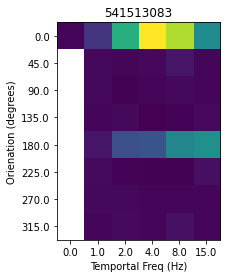

In [1067]:
another_dff = gratings.dfftraces[this_index]

another_response = np.zeros((len(stim_table),60))
for ii in range(len(stim_table)):
    orientation[ii] = stim_table.orientation[ii]
    temp_freq[ii] = stim_table.temporal_frequency[ii]
    another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

another_mean_response = another_response.mean(axis =1)

temp_freqs = np.unique(temp_freq)

tuning_array = np.empty((len(orientations),len(temp_freqs)))
for ii,ori in enumerate(orientations):
    for jj,tf in enumerate(temp_freqs):
        #print(ori)
        #print(tf)
        these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
        #print(sum(these_trials))
        tuning_array[ii,jj] = another_mean_response[these_trials].mean()
fig,ax = plt.subplots()
ax.imshow(tuning_array)
ax.set_xticks(range(len(temp_freqs)))
ax.set_xticklabels(temp_freqs)
ax.set_yticks(range(len(orientations)))
ax.set_yticklabels(orientations);
ax.set_xlabel("Temportal Freq (Hz)")
ax.set_ylabel("Orienation (degrees)")
ax.set_title(gratings.cell_id[this_index]);

So what did this teach us? If we split our data between trials with fast and slow temporal frequencies, we can identify cells (or, at least, a cell) where the model prediction is particularly bad accross conditions. This indicates that temporal frequency is a factor that should also be considered when looking at a cells tuning!

# (4) How can we mathematically formalize this analysis?

One hot encodeing

Regression using matrix math

Regression using SKlearn


Evaluation on held out data

Cross validation and the arbitrary choices that go with it.

What did we gain from all this? Add in another variable (running or temporal freq or something)

Model Comparison

# Code Graveyard.
Not ready to delete yet - some of it will be reformated to fill in the gaps above!

c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
c:\Users\yoni.browning\Anaconda3\envs\allensdk\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Orienation (degrees)')

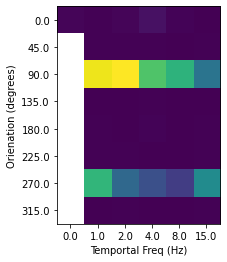

In [318]:
temp_freqs = np.unique(temp_freq)

tuning_array = np.empty((len(orientations),len(temp_freqs)))
for ii,ori in enumerate(orientations):
    for jj,tf in enumerate(temp_freqs):
        #print(ori)
        #print(tf)
        these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
        #print(sum(these_trials))
        tuning_array[ii,jj] = mean_response[these_trials].mean()
fig,ax = plt.subplots()
ax.imshow(tuning_array)
ax.set_xticks(range(len(temp_freqs)))
ax.set_xticklabels(temp_freqs)
ax.set_yticks(range(len(orientations)))
ax.set_yticklabels(orientations);
ax.set_xlabel("Temportal Freq (Hz)")
ax.set_ylabel("Orienation (degrees)")


<ipython-input-296-69dc6115fafe>:23: RuntimeWarning: Mean of empty slice.
  tuning_array[ii,jj] = another_mean_response[these_trials].mean()
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


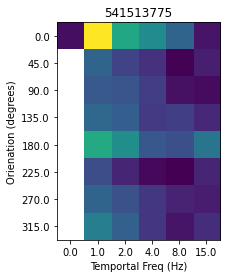

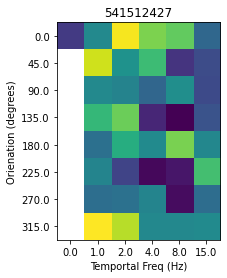

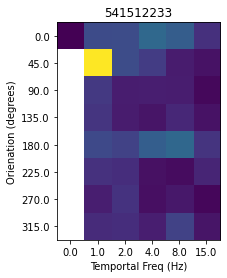

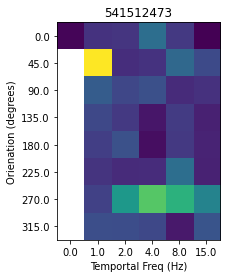

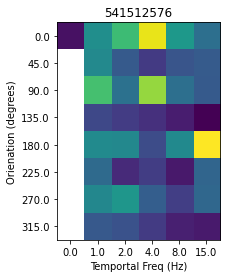

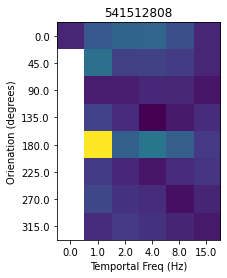

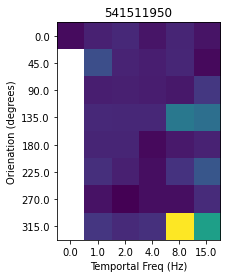

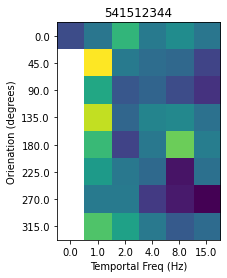

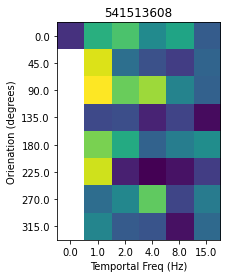

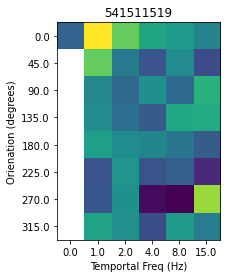

In [296]:
for ii in range(10):
    rand_cell_idx = np.random.randint(len(gratings.cell_id))

    another_dff = gratings.dfftraces[rand_cell_idx]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        orientation[ii] = stim_table.orientation[ii]
        temp_freq[ii] = stim_table.temporal_frequency[ii]
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

    another_mean_response = another_response.mean(axis =1)

    temp_freqs = np.unique(temp_freq)

    tuning_array = np.empty((len(orientations),len(temp_freqs)))
    for ii,ori in enumerate(orientations):
        for jj,tf in enumerate(temp_freqs):
            #print(ori)
            #print(tf)
            these_trials = np.bitwise_and(orientation==ori,temp_freq==tf)
            #print(sum(these_trials))
            tuning_array[ii,jj] = another_mean_response[these_trials].mean()
    fig,ax = plt.subplots()
    ax.imshow(tuning_array)
    ax.set_xticks(range(len(temp_freqs)))
    ax.set_xticklabels(temp_freqs)
    ax.set_yticks(range(len(orientations)))
    ax.set_yticklabels(orientations);
    ax.set_xlabel("Temportal Freq (Hz)")
    ax.set_ylabel("Orienation (degrees)")
    ax.set_title(gratings.cell_id[rand_cell_idx])


## We now interup our neuroscience programing
Up till now everything is descriptive- we are just looking at the data and describing it. What we really want to do is predict new data. In order to do this, we are going to fit a simple linear model that describes our tuning curve. Before we get that far, let's divert to the "DarwinExample" notebook to go though how model fitting and prediction might work on this kind of problem.

## Welcome back. 
This tuning curve problem can also be formulated as a one-hot encoding problem. -->Make this 1D

In [253]:
# Lets matrix for every stimulus condition
stims = np.vstack([orientation,temp_freq]).T

# Each stimulus condition has a unique identity
stimuli,stim_index,counts = np.unique(stims,axis=0,return_counts=True,return_inverse=True)

# How many are there?
print(len(stimuli))


41


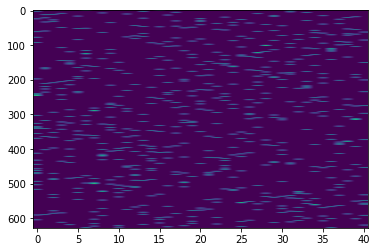

In [254]:
# Build the design matrix
X = np.zeros((len(stim_table),len(stimuli)))
for ii in range(len(stim_table)):
    X[ii,stim_index[ii]] = 1

fig,ax = plt.subplots()
ax.imshow(X,aspect='auto')

In [255]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, mean_response, test_size=0.5, random_state=42)


In [256]:
rfmodel = LinearRegression(fit_intercept=False).fit(X_train, y_train,)


In [257]:
# If we want to look at the model we fit, we can look at the predictions for any
# given stimulus. The easiest way to do this is to make a design matrix with a
# diagonal of all ones:
eyeX = np.eye(X.shape[1])
pred = rfmodel.predict(eyeX)

In [258]:
# Because we didn't fit an intercept, the predictions are the same as the as the
# model coefficients
rfmodel.coef_-pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

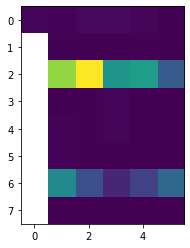

In [259]:
# We can plot the predicted response for each stimulus condition! This should
# look familiar... 
tuning_array = np.zeros((len(orientations),len(temp_freqs)))
for ii in range(len(pred)):
    ori_ix = np.where(orientations==stimuli[ii,0])[0]
    tf_ix = np.where(temp_freqs==stimuli[ii,1])[0]
    tuning_array[ori_ix,tf_ix]=pred[ii]
tuning_array[1:,0] = np.nan

fig,ax = plt.subplots()
ax.imshow(tuning_array)

In [260]:

scr_train = rfmodel.score(X_train,y_train)
scr_train

0.7941142710480253

In [261]:
# Now this is worse :(
scr_test = rfmodel.score(X_test,y_test)
scr_test

0.5737620030130027

In [219]:
train_prediction = np.zeros(len(gratings.cell_id))
test_prediction = np.zeros(len(gratings.cell_id))

for cc in range(len(gratings.dfftraces)):
    another_dff = gratings.dfftraces[cc]

    another_response = np.zeros((len(stim_table),60))
    for ii in range(len(stim_table)):
        orientation[ii] = stim_table.orientation[ii]
        temp_freq[ii] = stim_table.temporal_frequency[ii]
        another_response[ii,:] = another_dff[stim_table.start[ii]:stim_table.start[ii]+60]

    another_mean_response = another_response.mean(axis =1)

    another_X_train, another_X_test, another_y_train, another_y_test = train_test_split(X, another_mean_response, test_size=0.5,  random_state=42)
    
    rfmodel = LinearRegression(fit_intercept=False).fit(another_X_train, another_y_train,)
    train_prediction[cc] = rfmodel.score(another_X_train,another_y_train)

    test_prediction[cc] = rfmodel.score(another_X_test,another_y_test)


Text(0, 0.5, 'Test R^2')

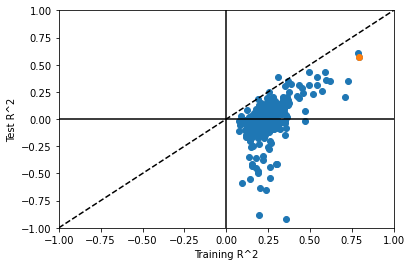

In [262]:
fig,ax = plt.subplots()
ax.scatter(train_prediction,test_prediction)
ax.scatter(scr_train,scr_test)

ax.plot([-1,1],[-1,1],'k--')
ax.plot([-1,1],[0,0],'k-')
ax.plot([0,0],[-1,1],'k-')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Training R^2")
ax.set_ylabel("Test R^2")

In [471]:
def orientation_selectivity(tuning,orientations):
    """
    Computes the orientation selectivity of a cell. The calculation of
    the orientation is done using the normalized
    circular variance (CirVar) as described in Ringbach 2002

    Parameters
    ----------
    ori_vals : complex array of length N
         Each value the oriention of the stimulus.
    tuning : float array of length N
        Each value the (averaged) response of the cell at a different
        orientation.

    Returns
    -------
    osi : float
        An N-dimensional array of the circular variance (scalar value,
        in radians) of the responses.
    """
    orivals_rad = np.deg2rad(orientations).astype('complex128')
    tuning_sum = tuning.sum()
    cv_top = tuning_a * np.exp(1j * 2 * orivals_rad)
    return np.abs(cv_top.sum()) / tuning_sum


AttributeError: module 'matplotlib.pyplot' has no attribute 'histogram'

In [ ]:
run_speed,run_ts = data_set.get_running_speed()
fig,ax = plt.subplots()
ax.plot(run_ts,run_speed)
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (cm/s)')   
